Goals:

Biopython: For calculating GC content, k-mer frequencies, ORFs, and more.


RepeatMasker: To find tandem or interspersed repeats.


HMMER/MEME Suite: For motif and pattern searches.


FASTA Tools: Command-line tools for sequence manipulation and statistics.


Features to target

GC/AT content


K-mer frequencies


Sequence length


Nucleotide skew


ORFs (if it's a coding sequence)


Palindromic sequences


Shannon entropy
Repeats and motifs (with computational tools)

In [ ]:
!pip install biopython
!pip install SeqIO


#fasta parser

install: missing destination file operand after 'unzip'
Try 'install --help' for more information.


In [10]:
# Unzip the file into a folder named 'dataset'
!unzip -q dataset.zip -d dataset

# Verify the contents of the 'dataset' folder
print("Contents extracted to 'dataset':")
!ls dataset


Contents extracted to 'dataset':
dataset


In [20]:
import os
from Bio import SeqIO
import pandas as pd

# Directory containing the datase
base_dir = "dataset"

# Function to parse a single .fna file and extract sequence
def parse_fna(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

def get_header_as_list(file_path):
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith(">"):  # Check if the line is a header
                return line.strip().split(" ")  # Strip newline and split by space
    return []

# Process all files in the dataset directory
data = []

for root, dirs, files in os.walk(base_dir):
    for file_name in files:
        if file_name.endswith(".fna"):
            # Determine folder name (e.g., 'regen' or 'non-regen')
            folder_name = os.path.basename(root)
            regen_value = 1 if folder_name.lower() == "regen" else 0  # regen: 1, non-regen: 0

            # Parse file
            gene_name = file_name.replace("axolotl_", "").replace("_.fna", "")
            file_path = os.path.join(root, file_name)
            sequences = parse_fna(file_path)

            first_line = get_header_as_list(file_path)

            organism = first_line[2].split("=")[1] + " " + first_line[3].strip("]")
            gene_id = first_line[4].split("=")[1].strip("]")
            chromosome = first_line[5].split("=")[1].strip("]")

            for seq in sequences:
                data.append({"gene_name": gene_name, "sequence": seq, "organism": organism, "gene_id": gene_id,"chromosome": chromosome, "regen": regen_value})

# Convert to DataFrame
df = pd.DataFrame(data)
print(f"Processed {len(df)} sequences.")
print(df.head())

# Save as a CSV for feature engineering
df.to_csv("processed_genes.csv", index=False)


Processed 81 sequences.
  gene_name                                           sequence  \
0      FASN  CCATTGGCCGGCCGCGAGGAGGGAGCTGTCAGCCCATGTGGCGTGT...   
1      GCGR  TGGAAAGTTTCTGTGTAGTGAGAGGTGACGGCTGACTACGGGGGAT...   
2    THAP11  TGTCACCGGAAGCTGTTAGCATTGTGGGACATGTAGTTCCGGTTCG...   
3      CDK2  ACCGTTTTGGGCGGGATCTCGAGAAGGCGGGAAGCTACGGCCCTAT...   
4      ATK1  GGAGCAGGAGCAGGCAGGCAGGCCAGGCCGGAGAGCAAGGAGCCAG...   

              organism    gene_id chromosome  regen  
0  Ambystoma mexicanum  138583256         3q      0  
1  Ambystoma mexicanum  138583226         3q      0  
2  Ambystoma mexicanum  138583276         1p      0  
3  Ambystoma mexicanum  138582470         3q      0  
4  Ambystoma mexicanum  138527104         14      0  


In [21]:
df.tail(5)

,gene_name,sequence,organism,gene_id,chromosome,regen
76,PSIP1,CAGCTGGTGGCAACTATGGCGAGCGCTGCAGTCGTGTGTTTATCTC...,Ambystoma mexicanum,138510412,6p,1
77,TGFBR1,GTACAGCCAATGACCCGGGGTGAGGGGGGATGAGGGGTTCAGGATC...,Ambystoma mexicanum,138497249,5q,1
78,MARCKSL1,GCGCAGACTCTGCACGGCTTTTGCGAGAGAAGCAGCGAGAGAGACC...,Ambystoma mexicanum,138503035,11,1
79,HOXA13,GGGGGCGGGCTGCCGCGCCAGCCCCGCTAAGGCTCGGCGGAGAGGG...,Ambystoma mexicanum,138569852,2q,1
80,LMX1B,ACACTCACTCCGTGACTGTTCTCTGGGAGCCCCGCAGACCCGCCGC...,Ambystoma mexicanum,138471656,8,1


In [22]:
import pandas as pd
from collections import Counter

# Function to compute k-mer frequencies
def compute_kmer_frequencies(sequence, k=3):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    kmer_counts = Counter(kmers)
    total_kmers = sum(kmer_counts.values())
    # Normalize counts
    kmer_frequencies = {f"kmer_{k}_{key}": val / total_kmers for key, val in kmer_counts.items()}
    return kmer_frequencies

# Function to compute GC content
def compute_gc_content(sequence):
    gc_count = sequence.count("G") + sequence.count("C")
    return gc_count / len(sequence) if len(sequence) > 0 else 0

# Function to compute AT/GC ratio
def compute_at_gc_ratio(sequence):
    at_count = sequence.count("A") + sequence.count("T")
    gc_count = sequence.count("G") + sequence.count("C")
    return at_count / gc_count if gc_count > 0 else 0

# Generate features for each sequence
features = []
for _, row in df.iterrows():
    sequence = row['sequence']
    feature_row = {
        "gene_name": row['gene_name'],
        "sequence_length": len(sequence),
        "gc_content": compute_gc_content(sequence),
        "at_gc_ratio": compute_at_gc_ratio(sequence),
    }
    # Add k-mer frequencies (e.g., k=3)
    feature_row.update(compute_kmer_frequencies(sequence, k=3))
    features.append(feature_row)

# Convert features to DataFrame
features_df = pd.DataFrame(features)

# Fill missing k-mers with zeros
features_df.fillna(0, inplace=True)

print(features_df.head())

# Save features to CSV for modeling
features_df.to_csv("gene_features.csv", index=False)


  gene_name  sequence_length  gc_content  at_gc_ratio  kmer_3_CCA  kmer_3_CAT  \
0      FASN           297582    0.482701     1.071678    0.019396    0.019470   
1      GCGR           800864    0.477238     1.095389    0.019511    0.019708   
2    THAP11             4237    0.447014     1.237064    0.012515    0.018182   
3      CDK2           185889    0.467290     1.140000    0.019883    0.017096   
4      ATK1           397239    0.473405     1.112355    0.021378    0.019444   

   kmer_3_ATT  kmer_3_TTG  kmer_3_TGG  kmer_3_GGC  ...  kmer_3_ATC  \
0    0.016305    0.017841    0.020949    0.014883  ...    0.012975   
1    0.017274    0.018671    0.021926    0.016394  ...    0.013160   
2    0.025974    0.022432    0.017946    0.014404  ...    0.009917   
3    0.018603    0.020469    0.020195    0.013336  ...    0.013879   
4    0.018002    0.020993    0.020622    0.013674  ...    0.014248   

   kmer_3_TCG  kmer_3_TCC  kmer_3_CCT  kmer_3_CTA  kmer_3_CAN  kmer_3_ANN  \
0    0.006472  

In [23]:
features_df

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_CCA,kmer_3_CAT,kmer_3_ATT,kmer_3_TTG,kmer_3_TGG,kmer_3_GGC,...,kmer_3_ATC,kmer_3_TCG,kmer_3_TCC,kmer_3_CCT,kmer_3_CTA,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA
0,FASN,297582,0.482701,1.071678,0.019396,0.019470,0.016305,0.017841,0.020949,0.014883,...,0.012975,0.006472,0.018170,0.019887,0.011829,0.0,0.0,0.0,0.0,0.0
1,GCGR,800864,0.477238,1.095389,0.019511,0.019708,0.017274,0.018671,0.021926,0.016394,...,0.013160,0.005987,0.017196,0.019570,0.012292,0.0,0.0,0.0,0.0,0.0
2,THAP11,4237,0.447014,1.237064,0.012515,0.018182,0.025974,0.022432,0.017946,0.014404,...,0.009917,0.007792,0.012987,0.016057,0.012279,0.0,0.0,0.0,0.0,0.0
3,CDK2,185889,0.467290,1.140000,0.019883,0.017096,0.018603,0.020469,0.020195,0.013336,...,0.013879,0.007370,0.018861,0.020034,0.011588,0.0,0.0,0.0,0.0,0.0
4,ATK1,397239,0.473405,1.112355,0.021378,0.019444,0.018002,0.020993,0.020622,0.013674,...,0.014248,0.006893,0.019152,0.020761,0.012695,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,PSIP1,828776,0.483298,1.069116,0.020267,0.016432,0.016552,0.018789,0.020326,0.015537,...,0.013305,0.008930,0.019619,0.020784,0.011936,0.0,0.0,0.0,0.0,0.0
77,TGFBR1,360240,0.465784,1.146918,0.020164,0.017244,0.017735,0.019384,0.019806,0.013591,...,0.013158,0.006707,0.017747,0.019043,0.011787,0.0,0.0,0.0,0.0,0.0
78,MARCKSL1,4852,0.611088,0.636425,0.018763,0.008041,0.009691,0.022887,0.039381,0.024330,...,0.005567,0.004536,0.015670,0.020000,0.010722,0.0,0.0,0.0,0.0,0.0
79,HOXA13,2800,0.522857,0.912568,0.016798,0.013581,0.017870,0.013581,0.021801,0.022873,...,0.005004,0.012152,0.009650,0.015726,0.008220,0.0,0.0,0.0,0.0,0.0


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop gene_name and separate features and target (assuming 'associated' as target column, update as needed)
X = features_df.drop(columns=['gene_name'])
y = (features_df['gc_content'] > 0.45).astype(int)  # Example: Binary target based on gc_content threshold

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)


In [32]:
X_train

array([[-0.6074117 ,  0.39668895, -0.39951225, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [ 0.93166629, -0.18690009,  0.02412133, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [ 1.85739106,  0.07811159, -0.17695302, ...,  8.94427191,
         8.94427191,  8.94427191],
       ...,
       [ 0.25817972,  0.14295862, -0.22262442, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.52789804,  0.76073721, -0.63577592, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.15288892,  0.25572492, -0.30255266, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ]])

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


# Adjusting CNN-LSTM for tabular data
model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=20,                 # Maximum number of epochs
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.6875 - loss: 0.6836 - val_accuracy: 0.8235 - val_loss: 0.6647
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7667 - loss: 0.6597 - val_accuracy: 0.8235 - val_loss: 0.6388
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6938 - loss: 0.6523 - val_accuracy: 0.8235 - val_loss: 0.6109
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7583 - loss: 0.6160 - val_accuracy: 0.8235 - val_loss: 0.5715
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7917 - loss: 0.5569 - val_accuracy: 0.8235 - val_loss: 0.5268
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7333 - loss: 0.5819 - val_accuracy: 0.8235 - val_loss: 0.4853
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7875 - loss: 0.5059 - val_accuracy: 0.8235 - val_loss: 0.4357
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7250 - loss: 0.5898 - val_accuracy: 0.8235 - val_loss: 0.4184

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9412 - loss: 0.3199
Test Accuracy: 0.9412


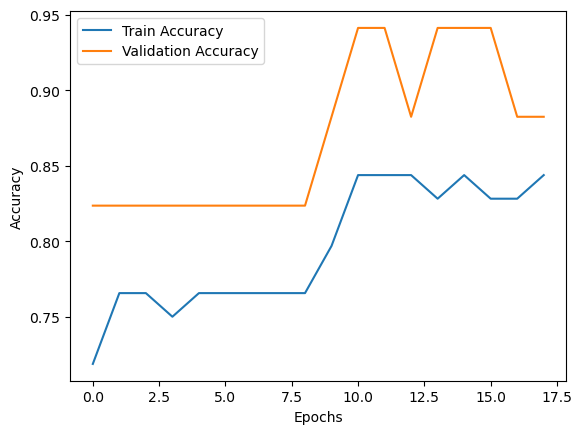

In [40]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


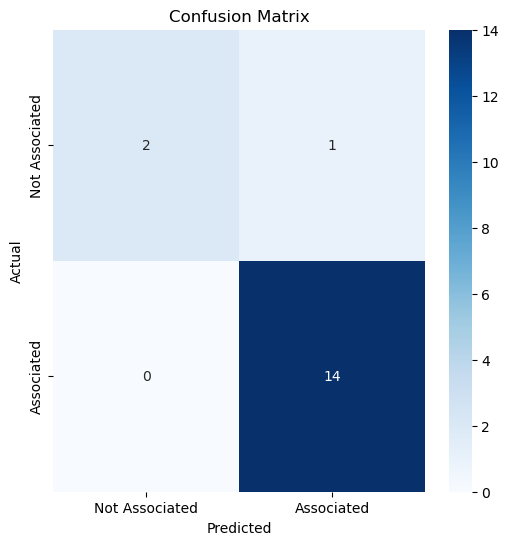

                precision    recall  f1-score   support

Not Associated       1.00      0.67      0.80         3
    Associated       0.93      1.00      0.97        14

      accuracy                           0.94        17
     macro avg       0.97      0.83      0.88        17
  weighted avg       0.95      0.94      0.94        17



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Not Associated", "Associated"]))


In [42]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


/home/jeremymillford/miniconda3_ub/envs/msse-python/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 18it [00:42,  2.86s/it]                        


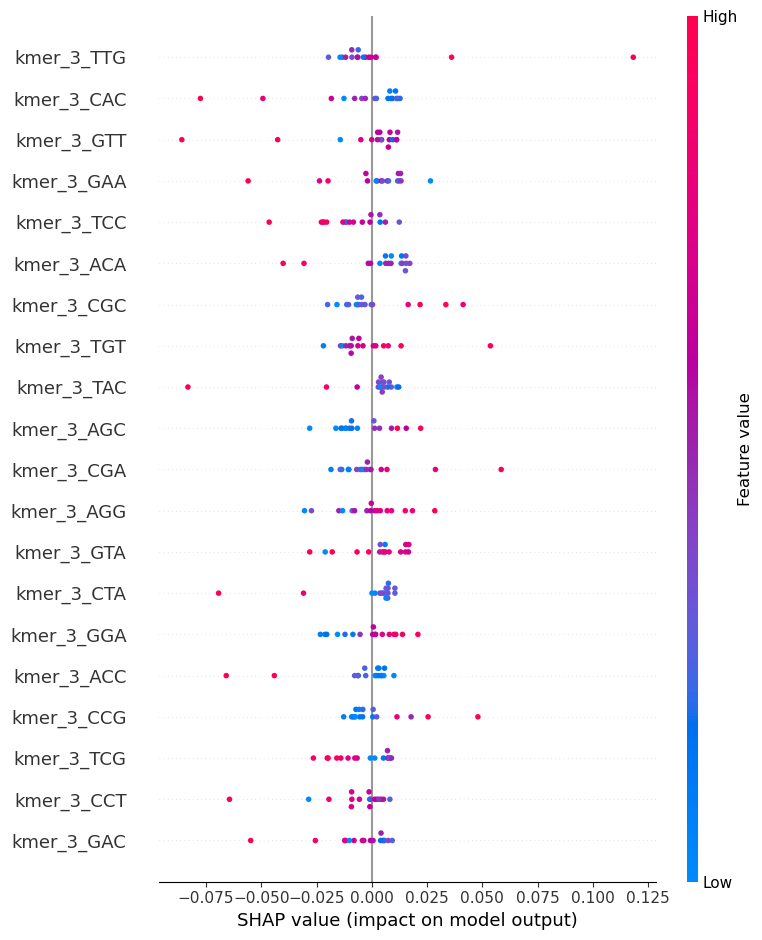

In [37]:
import shap #to show impactful features we are using

# Create SHAP explainer for your model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Display summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
